In [12]:
from tabu_search.algorithm import tabu_search, NeighborsTabuListInterface, TabuSearchResult
import numpy as np
from typing import Collection, Callable, Any, Tuple, List

REPS = 500
MAX_ITERS = 200
DPI = 150
ERROR_BAR = "pi"

# Part 1

In [13]:
EDGES = 9
COSTS = [20, 18, 19, 18, 9, 8, 10, 17, 29]
EDGE_MAPPING = {
    0: (1, 2),
    1: (1, 4),
    2: (4, 5),
    3: (2, 5),
    4: (1, 2),
    5: (3, 4),
    6: (2, 3),
    7: (3, 5),
    8: (1, 5),
}

In [14]:
def mst_cost(edges):
    base_cost = np.dot(COSTS, edges)
    penalty1 = MAX_ITERS if edges[4] + edges[5] > 2 * edges[8] else 0
    penalty2 = MAX_ITERS if edges[8] > edges[5] else 0
    return base_cost + penalty1 + penalty2


def cause_cycle(s: List) -> bool:
    visited = set()
    for i in range(len(s)):
        if s[i] > 0:
            visited.add(EDGE_MAPPING[i][0])
            visited.add(EDGE_MAPPING[i][1])
    return len(visited) < 5


class MSTNeighborTabu(NeighborsTabuListInterface):
    def __init__(self, tenure: int, nbrs_size: int, cost: Callable[[Collection], float]):
        super().__init__(tenure, nbrs_size, cost)
        self.tabu_list = []

    def neighbors(self, s_current: List) -> Tuple[Collection, Collection]:
        nbrs = []
        attrs = []

        def try_generate_neighbor():
            # picks an edge, if it's already picked, then i2_candidates are unpicked edges and vice versa
            i1_try = np.random.randint(8)
            i1_flag = s_current[i1_try]
            i2_candidates = [i for i in range(len(s_current)) if s_current[i] != i1_flag]

            # for each candidate, test swapping and checks for cycle
            for i2_candidate in i2_candidates:
                clone = s_current[:]

                # swaps edges
                clone[i1_try] = (clone[i1_try] + 1) % 2
                clone[i2_candidate] = (clone[i2_candidate] + 1) % 2

                # checks for cycle, if no cycle after swap then assign
                if not cause_cycle(clone):
                    return i1_try, i2_candidate

            # if generated candidates did not help, throw everything away
            return None, None

        for _ in range(self.nbrs_size):
            # repeat the above part until assigned
            i1, i2 = try_generate_neighbor()
            while i1 is None and i2 is None:
                i1, i2 = try_generate_neighbor()

            copied = s_current[:]
            copied[i1] = (copied[i1] + 1) % 2
            copied[i2] = (copied[i2] + 1) % 2

            # nbrs => the new neighbor, i1 will always be the inserted edge
            nbrs.append(copied)
            if copied[i1] == 1:
                attrs.append((i1, i2))
            else:
                attrs.append((i2, i1))

        return nbrs, attrs

    def add(self, attr: int, _):
        i1, _ = attr
        if len(self.tabu_list) >= self.tenure:
            self.tabu_list.pop(0)
        self.tabu_list.append(i1)

    def evaluate(self, s_current: Collection, _) -> float:
        return self.cost(s_current)

    def is_tabu(self, attr: Any, _):
        return attr[0] in self.tabu_list



In [15]:
s0 = [1, 0, 0, 0, 1, 1, 0, 1, 0]

res = tabu_search(mst_cost, s0, MSTNeighborTabu(3, 4, mst_cost), MAX_ITERS)
res.cost, res.solution

(63, [0, 1, 0, 1, 0, 0, 1, 1, 0])

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

In [17]:
def form_result(results: List[TabuSearchResult], max_iters=MAX_ITERS) -> pd.DataFrame:
    dfs = [
        pd.DataFrame({
            "Iteration": np.arange(max_iters + 1),
            "Best progress": result.progress_best,
            "Current progress": result.progress_current,
        }) for result in results
    ]
    combined = pd.concat(dfs).set_index("Iteration")
    combined["Optimal"] = mst_cost([0, 0, 0, 0, 1, 1, 1, 0, 1])
    return combined

<Axes: xlabel='Iteration'>

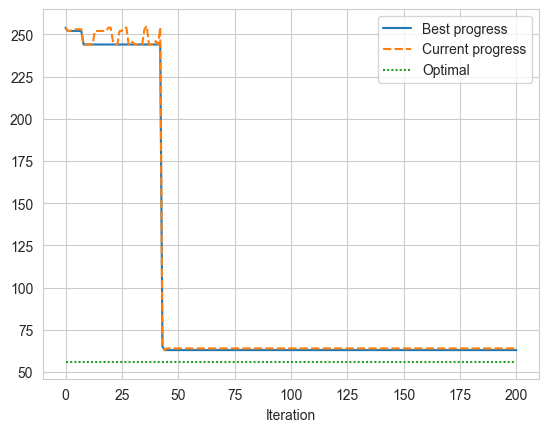

In [18]:
sns.lineplot(form_result([res]))

In [19]:
mst_cost([0, 0, 0, 0, 1, 1, 1, 0, 1])

56

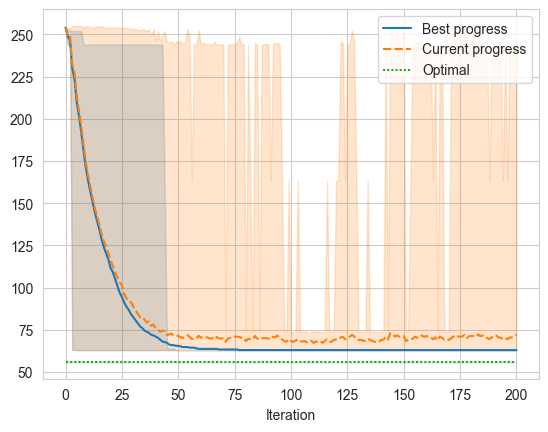

In [20]:
added34s = [tabu_search(mst_cost, s0, MSTNeighborTabu(2, 4, mst_cost), MAX_ITERS) for _ in range(REPS)]
added34s_df = form_result(added34s)
sns.lineplot(added34s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p2/default", dpi=DPI, bbox_inches="tight")

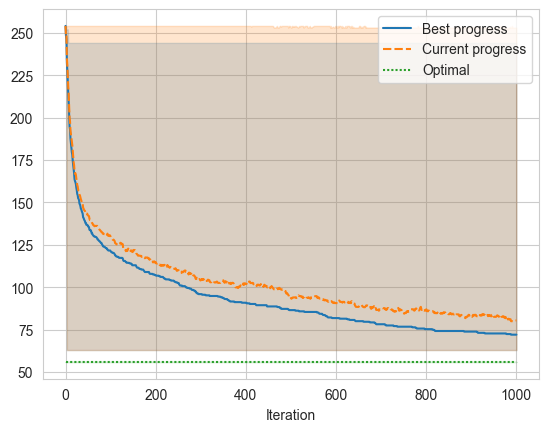

In [21]:
added34s = [tabu_search(mst_cost, s0, MSTNeighborTabu(4, 5, mst_cost), 1000) for _ in range(REPS)]
added34s_df = form_result(added34s, 1000)
sns.lineplot(added34s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p2/small-incr", dpi=DPI, bbox_inches="tight")

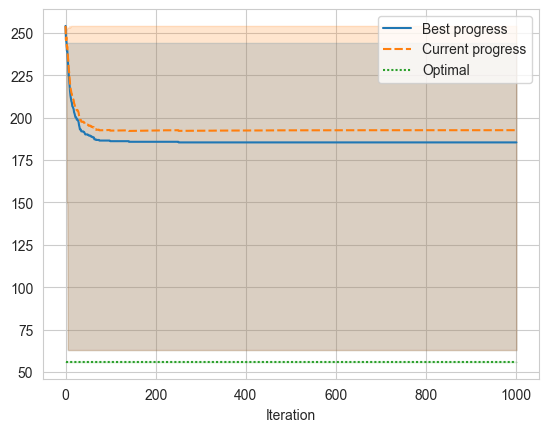

In [22]:
high = [tabu_search(mst_cost, s0, MSTNeighborTabu(6, 10, mst_cost), 1000) for _ in range(REPS)]
high_df = form_result(high, 1000)
sns.lineplot(high_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p2/large-incr", dpi=DPI, bbox_inches="tight")